<a href="https://colab.research.google.com/github/jjone36/Groot/blob/master/96_cnn_Doodle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Catch Doodle!: Quick draw

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style='white', context='notebook')

In [0]:
import ast

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Load data

In [4]:
# Connecting to kaggle API
from google.colab import files
file = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
from getpass import getpass
user = 'jjone36'
key = ''

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c quickdraw-doodle-recognition

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test_raw.csv: Skipping, found more recently modified local copy (use --force to force download)
test_simplified.csv: Skipping, found more recently modified local copy (use --force to force download)
train_raw.zip: Skipping, found more recently modified local copy (use --force to force download)
100% 7.36G/7.37G [02:27<00:00, 75.7MB/s]
100% 7.37G/7.37G [02:28<00:00, 53.5MB/s]


In [0]:
# Unzip the file
from zipfile import ZipFile
zf = ZipFile('train_simplified.zip', 'r')

In [0]:
# list of animals 
animals = ['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat', 'cow',
           'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck', 'elephant', 'fish',
           'flamingo', 'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl', 'panda',
           'parrot', 'penguin', 'pig', 'rabbit', 'raccoon', 'rhinoceros', 'scorpion',
           'sea turtle', 'shark', 'sheep', 'snail', 'snake', 'spider', 'squirrel',
           'swan', 'teddy-bear', 'tiger', 'whale', 'zebra']

In [0]:
# Import data: animals only
for a in animals:
  file = a + str('.csv')
  zf.extract(file, path= '/content/animals')

In [4]:
dir_path = '/content/animals/'

am = pd.read_csv(dir_path + animals[0] + '.csv')
am.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[27, 17, 16, 21, 34, 50, 49, 34, 23, 17], [4...",5421013154136064,True,2017-03-27 00:14:57.310330,ant
1,US,"[[[27, 0, 7, 40, 47, 20], [0, 41, 74, 73, 41, ...",4836123148812288,True,2017-03-06 20:00:22.521560,ant
2,US,"[[[34, 18, 14, 4, 1, 2, 10, 18, 46, 69, 83, 89...",5720952853757952,True,2017-01-23 19:53:28.354530,ant
3,US,"[[[59, 33, 16, 10, 61, 71, 69], [33, 36, 46, 5...",6345979559149568,True,2017-03-14 14:52:27.521410,ant
4,US,"[[[17, 16, 19], [140, 167, 177]], [[81, 82, 87...",4704383923126272,True,2017-01-25 21:48:31.256400,ant


In [0]:
# Take only recognizable drawings
am = am[am.recognized == True]

In [0]:
# Attach other files into one dataframe
for a in animals[1:]:
    df = pd.read_csv(dir_path + a + '.csv')
    df = df[df.recognized == True]
    am = am.append(df)

In [10]:
# Checking
am.word.nunique()

50

In [0]:
am = am.sample(frac = 1).reset_index(drop = True)

## Data Distribution check

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


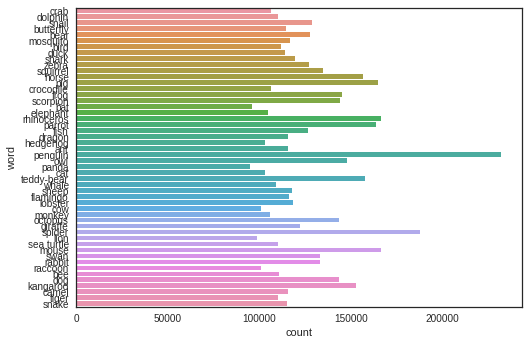

In [17]:
# Distributions of animals
sns.countplot(y = 'word', data = am)

In [0]:
# Resampling 
n = 100000
am_2 = pd.DataFrame(columns= am.columns)

for a in animals:
  df = am[am['word'] == a]
  if len(df) > n:
    df = df.sample(n)
    am_2 = am_2.append(df)
  else:
    am_2 = am_2.append(df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


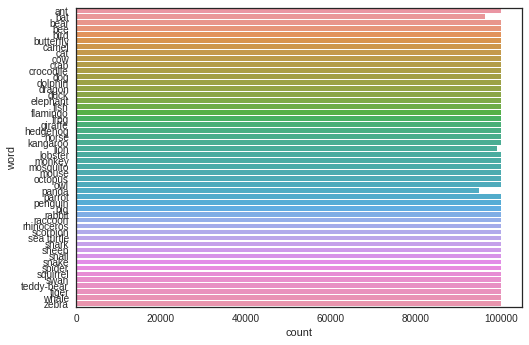

In [8]:
# Checking again
sns.countplot(y = 'word', data = am_2)

In [0]:
# Reindexing
am_2 = am_2.sample(frac = 1).reset_index(drop = True)

## Let's draw doodle!

In [10]:
am_2.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,TH,"[[[54, 49, 41, 6, 0, 36, 55], [1, 0, 10, 24, 3...",5195308025774080,True,2017-03-17 20:37:39.442300,crocodile
1,RS,"[[[22, 4, 0, 5, 11, 25, 49, 71, 75, 75, 83, 97...",6348232399519744,True,2017-01-03 13:11:36.979050,horse
2,IT,"[[[54, 61, 78, 89, 101, 103, 98, 86, 76, 68, 6...",6623138278277120,True,2017-03-01 12:29:18.864680,snail
3,SE,"[[[115, 84, 67, 51, 38, 33, 36, 45, 62, 70, 81...",5424054108422144,True,2017-03-04 14:01:08.373480,penguin
4,AU,"[[[0, 16, 39, 72, 119, 137, 172, 223, 253, 255...",6314032048898048,True,2017-03-19 23:47:39.664270,snake


In [0]:
ex = am_2.sample(100)

In [0]:
ex['drawing'] = ex.drawing.apply(ast.literal_eval)

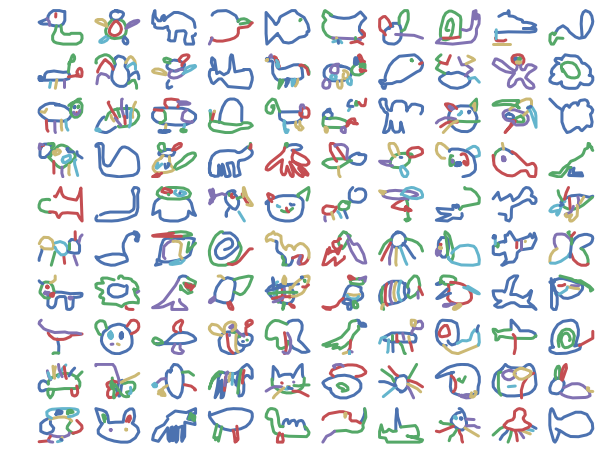

In [21]:
fig, axs = plt.subplots(nrows = 10, ncols = 10, figsize = (10, 8))

for index, col in enumerate(ex.drawing):
    ax = axs[index//10, index%10]
    for x, y in col:
        ax.plot(x,-np.array(y), lw = 3)
        i += 1
    ax.axis('off')
    
plt.show()

## Data preprocessing

In [0]:
im_size = 32
n_class = len(animals)

In [0]:
y = am_2.word
X = am_2.drawing

In [0]:
# Encodding
y = pd.get_dummies(y)

In [0]:
# Split the validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .3, random_state = 36)

In [55]:
X_train.reshape(X_train.shape[0], im_size, im_size, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [53]:
np.sqrt(X_val.shape[0] / 3)

706.3953095352016

In [40]:
# transform into Image data
X.reshape(-1, im_size, im_size, 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


ValueError: ignored

## Modeling

In [0]:
n_epochs = 10
batch_size = 512

In [0]:
# Initialize
model = Sequential()

# ConvNet_1
model.add(Conv2D(128, kernel_size = 3, input_shape = (im_size, im_size, 3), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(2, strides = 2))

# ConvNet_2
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(2, strides = 2))

# Flattening
model.add(Flatten())

# Fully connected
model.add(Dense(512, activation = 'relu'))

# Dropout
model.add(Dropout(.5))

# Final layer
model.add(Dense(n_class), activation = 'softmax')

# Compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.summary()

In [0]:
# Callback
stopper = EarlyStopping(patience = 3)

reducer = ReduceLROnPlateau(monitor = 'val_acc',
                           patience = 3,
                           verbose = 1,
                           factor = .5,
                           min_lr = 0.00001)

callbacks = [stopper, reducer]

In [0]:
history = model.fit(X_train, y_train, epochs = n_epoch, batch_size = batch_size, validation_split = .2, verbose = True)

## Plot the result